In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.formula.api as smf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import skew  # Import for skewness calculation
import scipy.stats as stats
import pylab
import seaborn as sns
import pickle

In [2]:
df = pd.read_csv(r"D:\Data Science & AI\Projects\Main Projects\Medical Inventery Management\Medical Inventory Optimaization Dataset.csv")

In [3]:
# Define a function to parse dates with different formats
def parse_date(date_str):
    for fmt in ("%m/%d/%Y", "%d-%m-%Y"):
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    return pd.NaT

In [4]:
df['Dateofbill'] = df['Dateofbill'].apply(parse_date)

In [5]:
df['Dateofbill'] = df['Dateofbill'].dt.strftime('%Y-%m-%d')

In [6]:
df.head(10)

,Typeofsales,Patient_ID,Specialisation,Dept,Dateofbill,Quantity,ReturnQuantity,Final_Cost,Final_Sales,RtnMRP,Formulation,DrugName,SubCat,SubCat1
0,Sale,12018098765,Specialisation6,Department1,2022-06-01,1,0,55.406,59.260,0.000,Form1,ZINC ACETATE 20MG/5ML SYP,SYRUP & SUSPENSION,VITAMINS & MINERALS
1,Sale,12018103897,Specialisation7,Department1,2022-07-23,1,0,768.638,950.800,0.000,Form1,CEFTAZIDIME 2GM+AVIBACTAM 500MG,INJECTIONS,ANTI-INFECTIVES
2,Sale,12018101123,Specialisation2,Department3,2022-06-23,1,0,774.266,4004.214,0.000,Form2,EPTIFIBATIDE 0.75MG/ML,INJECTIONS,CARDIOVASCULAR & HEMATOPOIETIC SYSTEM
3,Sale,12018079281,Specialisation40,Department1,2022-03-17,2,0,40.798,81.044,0.000,Form1,WATER FOR INJECTION 10ML SOLUTION,INJECTIONS,INTRAVENOUS & OTHER STERILE SOLUTIONS
4,Sale,12018117928,Specialisation5,Department1,2022-12-21,1,0,40.434,40.504,0.000,Form1,LORAZEPAM 1MG,TABLETS & CAPSULES,CENTRAL NERVOUS SYSTEM
5,Return,12018103662,Specialisation2,Department1,2022-07-15,0,8,47.902,0.000,330.288,Form1,SALBUTAMOL 2.5MG,INHALERS & RESPULES,RESPIRATORY SYSTEM
6,Sale,12018097585,Specialisation2,Department1,2022-05-22,1,0,41.862,42.218,0.000,Form1,FUROSEMIDE 10MG/ML,INJECTIONS,CARDIOVASCULAR & HEMATOPOIETIC SYSTEM
7,Sale,12018077721,Specialisation4,Department1,2022-01-12,3,0,60.026,142.752,0.000,Form1,SODIUM CHLORIDE IVF 100ML,"IV FLUIDS, ELECTROLYTES, TPN",INTRAVENOUS & OTHER STERILE SOLUTIONS
8,Sale,12018096500,Specialisation4,Department2,2022-08-24,2,0,49.856,94.000,0.000,Form2,SODIUM BICARBONATE 8.5% INJ,INJECTIONS,INTRAVENOUS & OTHER STERILE SOLUTIONS
9,Sale,12018071649,Specialisation4,Department1,2022-08-31,1,0,258.860,319.800,0.000,Form1,PEPTIDE BASED DIET POWDER,NUTRITIONAL SUPPLEMENTS,NUTRITION


In [7]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [8]:
df.shape

(14218, 14)

In [9]:
df.dtypes

Typeofsales        object
Patient_ID          int64
Specialisation     object
Dept               object
Dateofbill         object
Quantity            int64
ReturnQuantity      int64
Final_Cost        float64
Final_Sales       float64
RtnMRP            float64
Formulation        object
DrugName           object
SubCat             object
SubCat1            object
dtype: object

In [10]:
# type casting 
df["Patient_ID"] = df["Patient_ID"].astype('str')
df["Final_Sales"] = df["Final_Sales"].astype('float32')
df["Final_Cost"] = df["Final_Cost"].astype('float32')

In [11]:
df.dtypes

Typeofsales        object
Patient_ID         object
Specialisation     object
Dept               object
Dateofbill         object
Quantity            int64
ReturnQuantity      int64
Final_Cost        float32
Final_Sales       float32
RtnMRP            float64
Formulation        object
DrugName           object
SubCat             object
SubCat1            object
dtype: object

In [12]:
# Handling Duplicates
duplicate = df.duplicated()  
sum(duplicate)

26

In [13]:
# Remove duplicates
df = df.drop_duplicates() 
duplicate = df.duplicated()
sum(duplicate) 

0

In [14]:
df.replace('', pd.NA, inplace=True)

In [15]:
df.isnull().sum()

Typeofsales          0
Patient_ID           0
Specialisation       0
Dept                 0
Dateofbill           0
Quantity             0
ReturnQuantity       0
Final_Cost           0
Final_Sales          0
RtnMRP               0
Formulation        650
DrugName          1659
SubCat            1659
SubCat1           1682
dtype: int64

In [16]:
group_cols = ['Typeofsales', 'Specialisation', 'Dept']

In [17]:
# Impute missing values in Formulation column based on the mode of the group
def fill_missing_with_mode(df, group_cols, target_col):
    grouped = df.groupby(group_cols)[target_col]
    modes = grouped.transform(lambda x: x.mode().iloc[0] if not x.mode().empty else x)
    df[target_col] = df[target_col].fillna(modes)

In [18]:
mode_impute_cols = ['Formulation', 'DrugName', 'SubCat', 'SubCat1']

In [19]:
for col in mode_impute_cols:
    fill_missing_with_mode(df, group_cols, col)

In [20]:
df.isnull().sum()

Typeofsales       0
Patient_ID        0
Specialisation    0
Dept              0
Dateofbill        0
Quantity          0
ReturnQuantity    0
Final_Cost        0
Final_Sales       0
RtnMRP            0
Formulation       3
DrugName          6
SubCat            6
SubCat1           6
dtype: int64

In [21]:
df.dropna(inplace=True)
df= df.reset_index(drop=True)
df.isnull().sum()

Typeofsales       0
Patient_ID        0
Specialisation    0
Dept              0
Dateofbill        0
Quantity          0
ReturnQuantity    0
Final_Cost        0
Final_Sales       0
RtnMRP            0
Formulation       0
DrugName          0
SubCat            0
SubCat1           0
dtype: int64

In [22]:
date_column = 'Dateofbill'
df[date_column] = pd.to_datetime(df[date_column])
# Sort dataset by date column in ascending order
df = df.sort_values(by=date_column, ascending=True)

In [23]:
# Specify Final Cost column to round
column_name = 'Final_Cost'

# Specify number of decimal places to round to 0
decimal_places = 0

# Round the values in the column to 0
df[column_name] = df[column_name].apply(
    lambda x: round(x, decimal_places))

# Specify Final Sales column to round
column_name1 = 'Final_Sales'

# Specify number of decimal places to round to 0
decimal_places1 = 0

# Round values in the column to 0
df[column_name1] = df[column_name1].apply(
    lambda x: round(x, decimal_places1))

In [24]:
df.drop(columns=["ReturnQuantity"], axis=1, inplace=True)

In [25]:
df.head(10)

,Typeofsales,Patient_ID,Specialisation,Dept,Dateofbill,Quantity,Final_Cost,Final_Sales,RtnMRP,Formulation,DrugName,SubCat,SubCat1
13062,Sale,12018072643,Specialisation11,Department1,2022-01-01,5,87.0,304.0,0.00,Form1,PANTOPRAZOLE 40MG INJ,INJECTIONS,INTRAVENOUS & OTHER STERILE SOLUTIONS
2433,Sale,12018080296,Specialisation27,Department1,2022-01-01,3,66.0,449.0,0.00,Form1,PARACETAMOL 1GM IV INJ,INJECTIONS,CENTRAL NERVOUS SYSTEM
9895,Sale,12018080633,Specialisation14,Department1,2022-01-01,1,78.0,126.0,0.00,Form2,ENOXAPARIN 40MG,INJECTIONS,CARDIOVASCULAR & HEMATOPOIETIC SYSTEM
14140,Sale,12018075045,Specialisation4,Department1,2022-01-01,1,48.0,50.0,0.00,Form1,FLUCONAZOLE 50MG TAB,TABLETS & CAPSULES,ANTI-INFECTIVES
3749,Sale,12018081111,Specialisation11,Department2,2022-01-01,1,45.0,47.0,0.00,Form1,EPHEDRINE 30MG,INJECTIONS,CARDIOVASCULAR & HEMATOPOIETIC SYSTEM
11030,Sale,12018076250,Specialisation5,Department1,2022-01-01,1,42.0,43.0,0.00,Form1,GLYCOPYRROLATE,INJECTIONS,MUSCULO-SKELETAL SYSTEM
12583,Sale,12018081448,Specialisation14,Department2,2022-01-01,5,87.0,304.0,0.00,Form1,SODIUM CHLORIDE 0.9%,INJECTIONS,INTRAVENOUS & OTHER STERILE SOLUTIONS
9755,Sale,12018081582,Specialisation3,Department1,2022-01-01,3,66.0,449.0,0.00,Form1,PARACETAMOL 1GM IV INJ,INJECTIONS,CENTRAL NERVOUS SYSTEM
6999,Sale,12018071876,Specialisation3,Department1,2022-01-01,1,65.0,75.0,0.00,Form1,THYROXINE SODIUM 25MCG TAB,TABLETS & CAPSULES,ENDOCRINE & METABOLIC SYSTEM
10879,Return,12018081506,Specialisation2,Department1,2022-01-01,0,132.0,0.0,336.76,Form1,ENOXAPARIN 60MG,INJECTIONS,CARDIOVASCULAR & HEMATOPOIETIC SYSTEM


In [26]:
df.describe()

,Dateofbill,Quantity,Final_Cost,Final_Sales,RtnMRP
count,14184,14184.000000,14184.000000,14184.000000,14184.000000
mean,2022-07-07 13:57:45.989847552,2.234490,124.692400,233.871898,29.144288
min,2022-01-01 00:00:00,0.000000,40.000000,0.000000,0.000000
25%,2022-04-10 00:00:00,1.000000,45.000000,48.000000,0.000000
50%,2022-07-11 00:00:00,1.000000,54.000000,86.000000,0.000000
75%,2022-10-04 06:00:00,2.000000,78.000000,181.000000,0.000000
max,2022-12-31 00:00:00,150.000000,33178.000000,39490.000000,8014.000000
std,NaN,5.137742,465.096326,671.491922,182.462466


In [27]:
numeric_cols = df.select_dtypes(include=['int64', 'float32', 'float64']).columns

In [28]:
for col in numeric_cols:
  print(f"Column: {col}")
  print(f"  Mean: {df[col].mean()}")
  print(f"  Median: {df[col].median()}")
  print(f"  Mode: {df[col].mode().iloc[0]}")  # Assuming single mode for simplicity
  print(f"  Variance: {df[col].var()}")
  print(f"  Standard Deviation: {df[col].std()}")
  print(f"  Skewness: {skew(df[col])}")  # Using scipy.stats for skewness
  print(f"  Kurtosis: {df[col].kurt()}")  # Kurtosis using pandas
  print("-" * 20)  # Separator between columns

Column: Quantity
  Mean: 2.2344895657078396
  Median: 1.0
  Mode: 1
  Variance: 26.396396228188014
  Standard Deviation: 5.1377423279284855
  Skewness: 11.327695459040598
  Kurtosis: 179.75556416220294
--------------------
Column: Final_Cost
  Mean: 124.69239988719684
  Median: 54.0
  Mode: 42.0
  Variance: 216314.59218365306
  Standard Deviation: 465.0963257043137
  Skewness: 34.515912412455165
  Kurtosis: 2025.2834209195448
--------------------
Column: Final_Sales
  Mean: 233.87189791314157
  Median: 86.0
  Mode: 0.0
  Variance: 450901.4009898075
  Standard Deviation: 671.4919217606474
  Skewness: 21.030715596060183
  Kurtosis: 949.5135104970497
--------------------
Column: RtnMRP
  Mean: 29.14428807106599
  Median: 0.0
  Mode: 0.0
  Variance: 33292.551495890766
  Standard Deviation: 182.46246599202468
  Skewness: 15.781549349226616
  Kurtosis: 402.70868618837704
--------------------


In [29]:
# No mode calculation for non-numeric columns (use value counts instead)
for col in df.columns:
  if col not in numeric_cols:
    print(f"Column: {col}")
    print(f"  Most frequent value: {df[col].mode().iloc[0]}")

Column: Typeofsales
  Most frequent value: Sale
Column: Patient_ID
  Most frequent value: 12018071649
Column: Specialisation
  Most frequent value: Specialisation4
Column: Dept
  Most frequent value: Department1
Column: Dateofbill
  Most frequent value: 2022-07-09 00:00:00
Column: Formulation
  Most frequent value: Form1
Column: DrugName
  Most frequent value: MULTIPLE ELECTROLYTES 500ML IVF
Column: SubCat
  Most frequent value: INJECTIONS
Column: SubCat1
  Most frequent value: INTRAVENOUS & OTHER STERILE SOLUTIONS


In [30]:
#EDA
df.Quantity.max()

150

In [31]:
df.Final_Cost.max()

33178.0

In [32]:
df.Final_Sales.max()

39490.0

In [33]:
df.RtnMRP.max()

8014.0

In [34]:
# Convert date formate to month
df['Dateofbill'] = pd.to_datetime(df['Dateofbill'])
df['Dateofbill'] = df['Dateofbill'].dt.strftime('%b')
df.head()

,Typeofsales,Patient_ID,Specialisation,Dept,Dateofbill,Quantity,Final_Cost,Final_Sales,RtnMRP,Formulation,DrugName,SubCat,SubCat1
13062,Sale,12018072643,Specialisation11,Department1,Jan,5,87.0,304.0,0.0,Form1,PANTOPRAZOLE 40MG INJ,INJECTIONS,INTRAVENOUS & OTHER STERILE SOLUTIONS
2433,Sale,12018080296,Specialisation27,Department1,Jan,3,66.0,449.0,0.0,Form1,PARACETAMOL 1GM IV INJ,INJECTIONS,CENTRAL NERVOUS SYSTEM
9895,Sale,12018080633,Specialisation14,Department1,Jan,1,78.0,126.0,0.0,Form2,ENOXAPARIN 40MG,INJECTIONS,CARDIOVASCULAR & HEMATOPOIETIC SYSTEM
14140,Sale,12018075045,Specialisation4,Department1,Jan,1,48.0,50.0,0.0,Form1,FLUCONAZOLE 50MG TAB,TABLETS & CAPSULES,ANTI-INFECTIVES
3749,Sale,12018081111,Specialisation11,Department2,Jan,1,45.0,47.0,0.0,Form1,EPHEDRINE 30MG,INJECTIONS,CARDIOVASCULAR & HEMATOPOIETIC SYSTEM


In [35]:
# Pivot the DataFrame based on SubCat of drugs
data_pivoted = df.pivot_table(index="SubCat", columns="Dateofbill", values="Quantity")

# Result
data_pivoted.head()

Dateofbill,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
SubCat,,,,,,,,,,,,
DROPS,0.888889,0.666667,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.666667,1.000000,1.000000,0.857143
INHALERS & RESPULES,2.360000,2.977778,2.722222,2.935484,3.666667,3.159091,3.266667,3.137931,4.052632,2.954545,3.088889,3.068182
INJECTIONS,2.782361,2.464607,2.405502,2.540490,2.329768,2.762735,2.283019,2.757296,2.577532,2.510760,2.634218,2.444142
"IV FLUIDS, ELECTROLYTES, TPN",1.869231,1.678445,1.592437,1.813636,1.942708,1.839844,2.050228,1.732218,1.706767,1.485207,1.622951,1.505376
LIQUIDS & SOLUTIONS,5.714286,6.300000,9.161290,4.294118,11.086957,4.666667,1.050000,11.375000,9.461538,13.400000,6.650000,1.095238


((array([-3.89614943, -3.67566244, -3.55482318, ...,  3.55482318,
          3.67566244,  3.89614943]),
  array([  0,   0,   0, ..., 100, 100, 150], dtype=int64)),
 (2.660232114547922, 2.234489565707839, 0.5176655056900048))

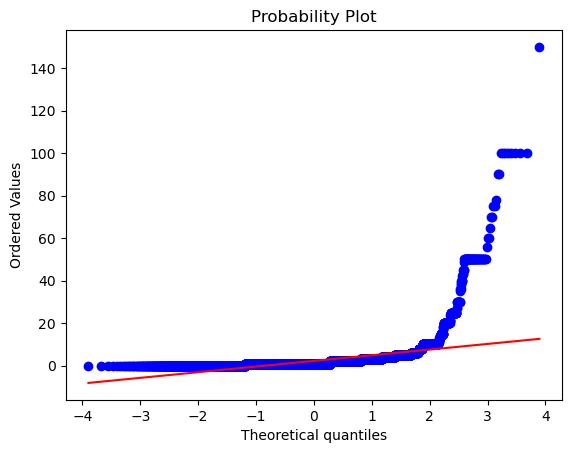

In [36]:
#Data Distribution
# Distribution of data
stats.probplot(df.Quantity, dist="norm", plot=pylab)

((array([-3.89614943, -3.67566244, -3.55482318, ...,  3.55482318,
          3.67566244,  3.89614943]),
  array([      -inf,       -inf,       -inf, ..., 4.60517019, 4.60517019,
         5.01063529])),
 (nan, nan, nan))

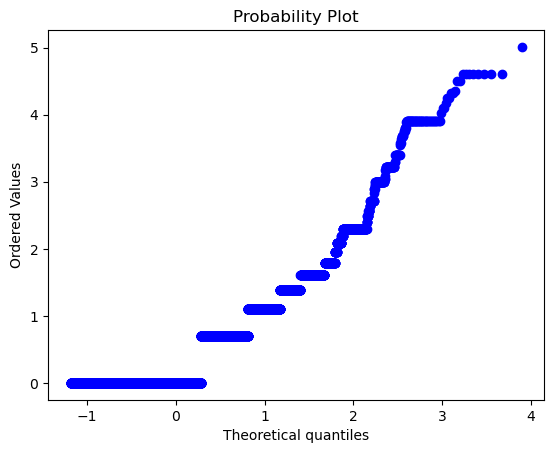

In [37]:
#Data Transformation : Log Transformation
# Transform the data to a normal distribution
stats.probplot(np.log(df.Quantity),dist="norm",plot=pylab)

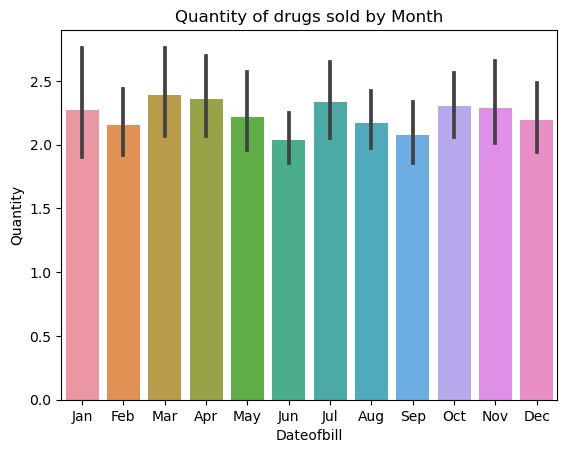

In [38]:
#Bar Plot (Quantity of drugs sold by Month)
sns.barplot(data = df, x = 'Dateofbill', y = 'Quantity')
plt.title('Quantity of drugs sold by Month')
plt.show()

In [39]:
# In March, April, July, and September has highest quantity sold. and it is approximately the same

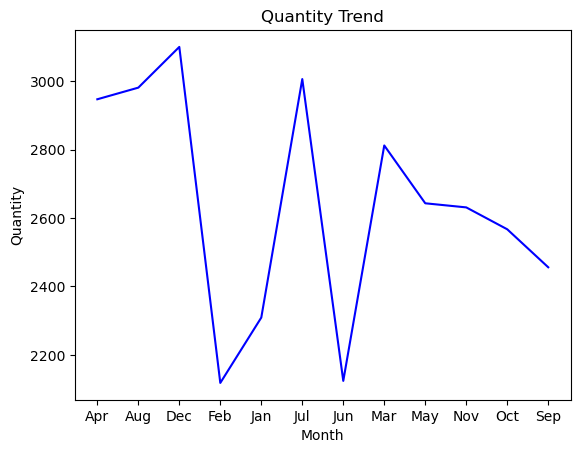

In [40]:
Month = df.groupby('Dateofbill')['Quantity'].sum()
plt.plot(Month.index, Month.values, color = 'blue')
plt.title('Quantity Trend')
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.show()

In [44]:
#AutoEDA (D-Tale)
import dtale as dt

In [45]:
d = dt.show(df)
d.open_browser()

In [46]:
df_grouped = df[['Dateofbill','Quantity']]

In [47]:
# Group by Quantity and Month
df_grouped = df_grouped.groupby('Dateofbill').sum()

# Result
df_grouped.head(10)
df_grouped = df_grouped.reset_index()
df_grouped

,Dateofbill,Quantity
0,Apr,2947
1,Aug,2981
2,Dec,3100
3,Feb,2118
4,Jan,2309
5,Jul,3006
6,Jun,2124
7,Mar,2812
8,May,2643
9,Nov,2631


In [48]:
# Create dictionary to map month names into numerical values
dict_month = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
              'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

# Create a new column with the numerical values of the months
df_grouped['Monthindex'] = df_grouped['Dateofbill'].map(dict_month)

df_grouped = df_grouped.sort_values(by='Monthindex')

In [49]:
# Drop Monthindex column
df_grouped = df_grouped.drop(columns=['Monthindex'])
df_grouped = df_grouped.reset_index(drop=True)
df_grouped

,Dateofbill,Quantity
0,Jan,2309
1,Feb,2118
2,Mar,2812
3,Apr,2947
4,May,2643
5,Jun,2124
6,Jul,3006
7,Aug,2981
8,Sep,2456
9,Oct,2567


In [50]:
#One-Hot Encoding
data1 = pd.get_dummies(df_grouped.Dateofbill)
data1.columns

Index(['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov',
       'Oct', 'Sep'],
      dtype='object')

In [51]:
# Concatenate df_grouped and data1 along columns
data = pd.concat([df_grouped, data1], axis=1)

In [52]:
data

,Dateofbill,Quantity,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,Jan,2309,False,False,False,False,True,False,False,False,False,False,False,False
1,Feb,2118,False,False,False,True,False,False,False,False,False,False,False,False
2,Mar,2812,False,False,False,False,False,False,False,True,False,False,False,False
3,Apr,2947,True,False,False,False,False,False,False,False,False,False,False,False
4,May,2643,False,False,False,False,False,False,False,False,True,False,False,False
5,Jun,2124,False,False,False,False,False,False,True,False,False,False,False,False
6,Jul,3006,False,False,False,False,False,True,False,False,False,False,False,False
7,Aug,2981,False,True,False,False,False,False,False,False,False,False,False,False
8,Sep,2456,False,False,False,False,False,False,False,False,False,False,False,True
9,Oct,2567,False,False,False,False,False,False,False,False,False,False,True,False


In [53]:
data['log_Quantity'] = np.log(data['Quantity'])
data

,Dateofbill,Quantity,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,log_Quantity
0,Jan,2309,False,False,False,False,True,False,False,False,False,False,False,False,7.744570
1,Feb,2118,False,False,False,True,False,False,False,False,False,False,False,False,7.658228
2,Mar,2812,False,False,False,False,False,False,False,True,False,False,False,False,7.941651
3,Apr,2947,True,False,False,False,False,False,False,False,False,False,False,False,7.988543
4,May,2643,False,False,False,False,False,False,False,False,True,False,False,False,7.879670
5,Jun,2124,False,False,False,False,False,False,True,False,False,False,False,False,7.661056
6,Jul,3006,False,False,False,False,False,True,False,False,False,False,False,False,8.008366
7,Aug,2981,False,True,False,False,False,False,False,False,False,False,False,False,8.000014
8,Sep,2456,False,False,False,False,False,False,False,False,False,False,False,True,7.806289
9,Oct,2567,False,False,False,False,False,False,False,False,False,False,True,False,7.850493


In [54]:
data["t"] = np.arange(1,13)

data["t_square"] = data["t"] * data["t"]
data

,Dateofbill,Quantity,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,log_Quantity,t,t_square
0,Jan,2309,False,False,False,False,True,False,False,False,False,False,False,False,7.744570,1,1
1,Feb,2118,False,False,False,True,False,False,False,False,False,False,False,False,7.658228,2,4
2,Mar,2812,False,False,False,False,False,False,False,True,False,False,False,False,7.941651,3,9
3,Apr,2947,True,False,False,False,False,False,False,False,False,False,False,False,7.988543,4,16
4,May,2643,False,False,False,False,False,False,False,False,True,False,False,False,7.879670,5,25
5,Jun,2124,False,False,False,False,False,False,True,False,False,False,False,False,7.661056,6,36
6,Jul,3006,False,False,False,False,False,True,False,False,False,False,False,False,8.008366,7,49
7,Aug,2981,False,True,False,False,False,False,False,False,False,False,False,False,8.000014,8,64
8,Sep,2456,False,False,False,False,False,False,False,False,False,False,False,True,7.806289,9,81
9,Oct,2567,False,False,False,False,False,False,False,False,False,False,True,False,7.850493,10,100


In [55]:
#Model Building
#Linear
# Data Partition
Train = data
Test = data

In [56]:
linear = smf.ols('Quantity ~ t', data = Train).fit()
pickle.dump(linear,open('linear_model.pkl','wb'))

In [57]:
pred_linear =  pd.Series(linear.predict(pd.DataFrame(Test['t'])))
mape_linear = np.mean(np.abs((Test['Quantity'] - (pred_linear)) / Test['Quantity'])) * 100
mape_linear

10.619729507907639

In [58]:
#Exponential
Exponential = smf.ols('log_Quantity ~ t', data = Train).fit()
pred_Exponential = pd.Series(Exponential.predict(pd.DataFrame(Test['t'])))

In [59]:
mape_Exponential = np.mean(np.abs((Test['Quantity'] - np.exp(pred_Exponential)) / Test['Quantity'])) * 100
mape_Exponential

10.579834407361473

In [60]:
#Quadratic
Quadratic = smf.ols('Quantity ~ t + t_square', data = Train).fit()
pred_Quadratic = pd.Series(Quadratic.predict(Test[["t", "t_square"]]))

In [61]:
mape_Quadratic = np.mean(np.abs((Test['Quantity'] - (pred_Quadratic)) / Test['Quantity'])) * 100
mape_Quadratic

10.242750686398157

In [62]:
#Additive Seasonality
addSeasonality = smf.ols('Quantity ~ Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec', data=Train).fit()
pred_addSeasonality = pd.Series(addSeasonality.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))

In [63]:
mape_addSeasonality = np.mean(np.abs((Test['Quantity'] - (pred_addSeasonality)) / Test['Quantity'])) * 100
mape_addSeasonality

2.5485796533665633e-14

In [64]:
#Multiplicative Seasonality
MulSeasonality = smf.ols('log_Quantity ~ Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = Train).fit()
pred_MultSeasonality = pd.Series(MulSeasonality.predict(Test))
mape_MultSeasonality = np.mean(np.abs((Test['Quantity'] - np.exp(pred_MultSeasonality)) / Test['Quantity'])) * 100
mape_MultSeasonality

1.4768848836281368e-13

In [65]:
#Additive Seasonality Quadratic Trend
add_seaQuadratic = smf.ols('Quantity ~ t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=Train).fit()
pred_add_seaQuadratic = pd.Series(add_seaQuadratic.predict(Test[['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov' , 'Oct' , 'Sep' ,'t','t_square']]))
mape_add_seaQuadratic = np.mean(np.abs((Test['Quantity'] - (pred_add_seaQuadratic)) / Test['Quantity'])) * 100
mape_add_seaQuadratic

1.8788541960054362e-13

In [66]:
#Multiplicative Seasonality Linear Trend
Mul_SeasonalityLinear = smf.ols('log_Quantity ~ t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = Train).fit()
pred_MultSeasonalityLinear = pd.Series(Mul_SeasonalityLinear.predict(Test))

In [67]:
mape_MultSeasonalityLinear = np.mean(np.abs((Test['Quantity'] - np.exp(pred_MultSeasonalityLinear)) / Test['Quantity'])) * 100
mape_MultSeasonalityLinear

4.079442888823599e-13

In [68]:
data1 = {"MODEL":pd.Series(["mape_linear","mape_Exponential","mape_Quadratic","mape_addSeasonality","mape_MultSeasonality","mape_add_seaQuadratic","mape_MultSeasonalityLinear"]),"MAPE_Values":pd.Series([mape_linear,mape_Exponential,mape_Quadratic,mape_addSeasonality,mape_MultSeasonality,mape_add_seaQuadratic,mape_MultSeasonalityLinear])}
table_mape = pd.DataFrame(data1)
table_mape

,MODEL,MAPE_Values
0,mape_linear,1.061973e+01
1,mape_Exponential,1.057983e+01
2,mape_Quadratic,1.024275e+01
3,mape_addSeasonality,2.548580e-14
4,mape_MultSeasonality,1.476885e-13
5,mape_add_seaQuadratic,1.878854e-13
6,mape_MultSeasonalityLinear,4.079443e-13


In [69]:
model_full = smf.ols('Quantity ~ t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=Train).fit()

In [70]:
predict_data = data
pred_new  = pd.Series(model_full.predict(predict_data))
pred_new

0     2309.0
1     2118.0
2     2812.0
3     2947.0
4     2643.0
5     2124.0
6     3006.0
7     2981.0
8     2456.0
9     2567.0
10    2631.0
11    3100.0
dtype: float64

In [71]:
predict_data["forecasted_Quantity"] = pd.Series(pred_new)

In [72]:
model_full.save("model.pickle")

In [73]:
# Load model
from statsmodels.regression.linear_model import OLSResults
model = OLSResults.load("model.pickle")

In [74]:
full_res = data.Quantity - model_full.predict(data)

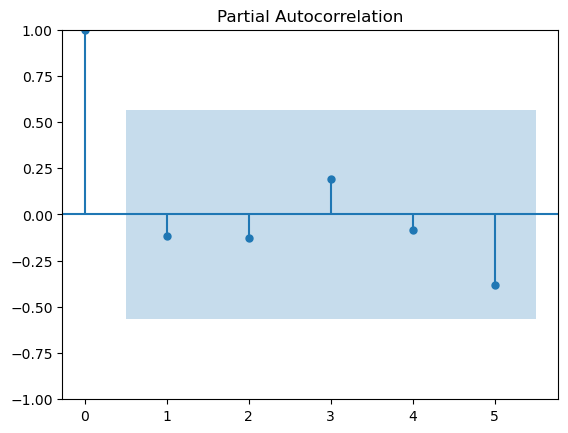

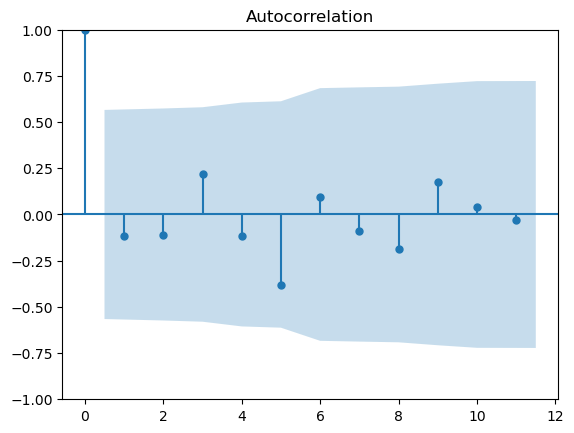

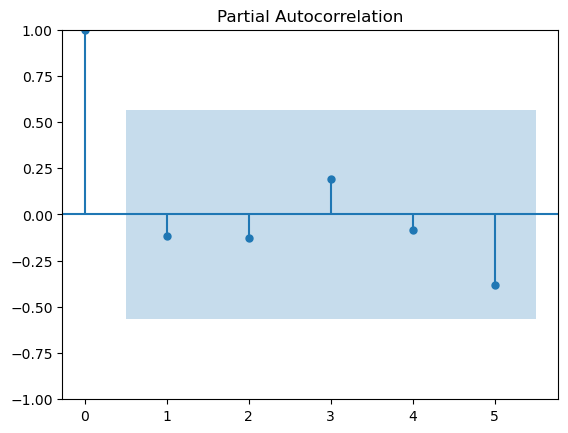

In [75]:
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.arima.model import ARIMA

tsa_plots.plot_acf(full_res, lags = 11)
tsa_plots.plot_pacf(full_res, lags = 5 )

In [76]:
# AR model
from statsmodels.tsa.ar_model import AutoReg
model_ar = AutoReg(full_res, lags=[1])

# model_ar = AutoReg(Train_res, lags=12)
model_fit = model_ar.fit()

print('Coefficients: %s' % model_fit.params)

pred_res = model_fit.predict(start=len(full_res), end=len(full_res)+len(predict_data)-1, dynamic=False)
pred_res.reset_index(drop=True, inplace=True)

# The Final Predictions using ASQT and AR(1) Model
final_pred = pred_new + pred_res
final_pred

Coefficients: const    4.186762e-12
y.L1    -1.189060e-01
dtype: float64


0     2309.0
1     2118.0
2     2812.0
3     2947.0
4     2643.0
5     2124.0
6     3006.0
7     2981.0
8     2456.0
9     2567.0
10    2631.0
11    3100.0
dtype: float64

In [77]:
train = df_grouped
test= df_grouped
train

,Dateofbill,Quantity
0,Jan,2309
1,Feb,2118
2,Mar,2812
3,Apr,2947
4,May,2643
5,Jun,2124
6,Jul,3006
7,Aug,2981
8,Sep,2456
9,Oct,2567


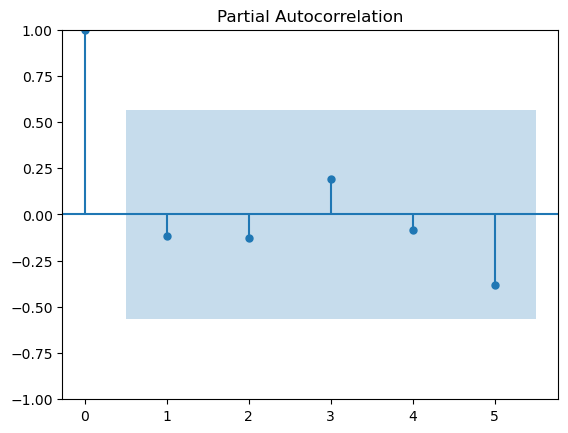

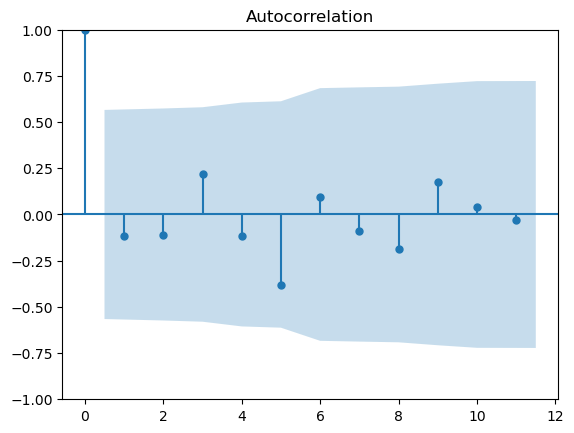

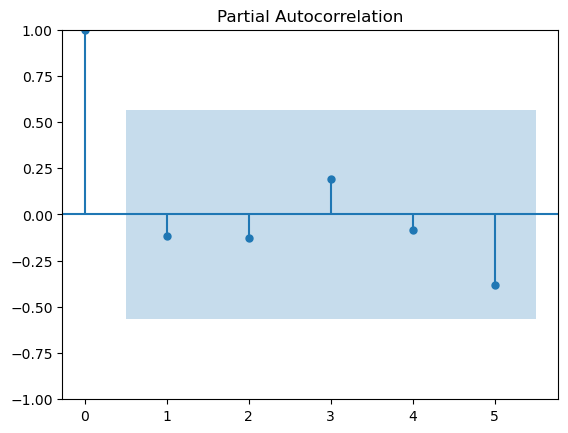

In [78]:
tsa_plots.plot_acf(full_res, lags = 11)
tsa_plots.plot_pacf(full_res, lags = 5 )

In [79]:
model1 = ARIMA(train.Quantity, order = (5,1,2))
res1 = model1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Quantity   No. Observations:                   12
Model:                 ARIMA(5, 1, 2)   Log Likelihood                 -99.292
Date:                Sun, 26 May 2024   AIC                            214.585
Time:                        11:27:28   BIC                            217.768
Sample:                             0   HQIC                           212.578
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7574      0.053    -14.195      0.000      -0.862      -0.653
ar.L2         -0.3120      0.021    -14.820      0.000      -0.353      -0.271
ar.L3          0.3083      0.021     14.703      0.000       0.267       0.349
ar.L4          0.7547      0.054     14.052      0.000       0.649       0.860
ar.L5          0.9990      0.000   3667.288      0.000       0.998       1.000
ma.L1          0.0015      0.994      0.002      0.999      -1.946       1.949
ma.L2         -0.9985      0.253     -3.947      0.000      -1.494      -0.503
sigma2      2237.1071      0.001   3.79e+06      0.000    2237.106    2237.108
===================================================================================
Ljung-Box (L1) (Q):                   1.31   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.25   Prob(JB):                         0.64
Heteroskedasticity (H):               0.95   Skew:                             0.21
Prob(H) (two-sided):                  0.96   Kurtosis:                         1.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.9e+22. Standard errors may be unstable.
"""

In [80]:
start_index = len(train)
start_index
end_index = start_index + 11
forecast_test = res1.predict(start = start_index, end = end_index)

In [81]:
forecast_test = pd.DataFrame(forecast_test)
forecast_test

,predicted_mean
12,2413.619912
13,2426.943491
14,2934.829778
15,2752.272865
16,2686.676717
17,2274.262667
18,2947.448249
19,2915.638379
20,2370.626020
21,2624.116366


In [82]:
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse_test = sqrt(mean_squared_error(test.Quantity, forecast_test))

print('test RMSE: %.3f' % rmse_test)

test RMSE: 131.942


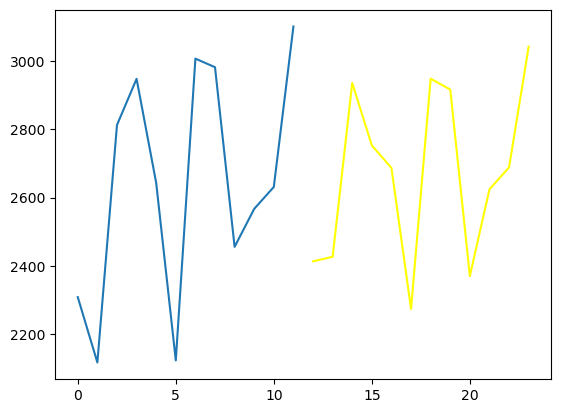

In [84]:
plt.plot(test.Quantity)
plt.plot(forecast_test, color = 'yellow')
plt.show()

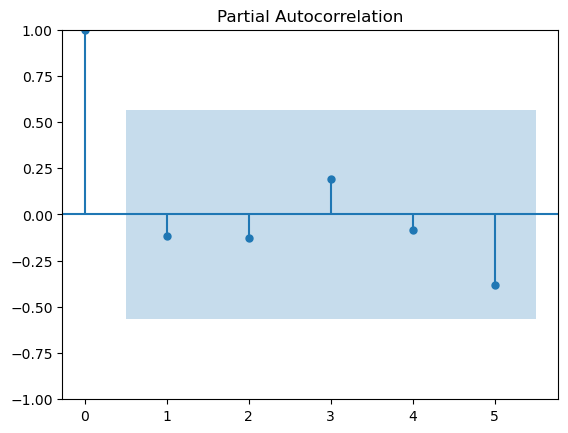

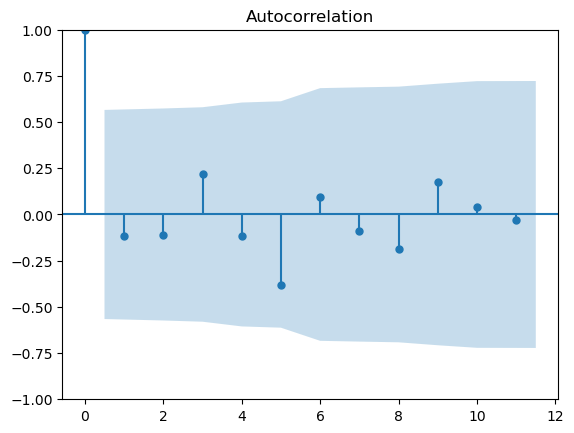

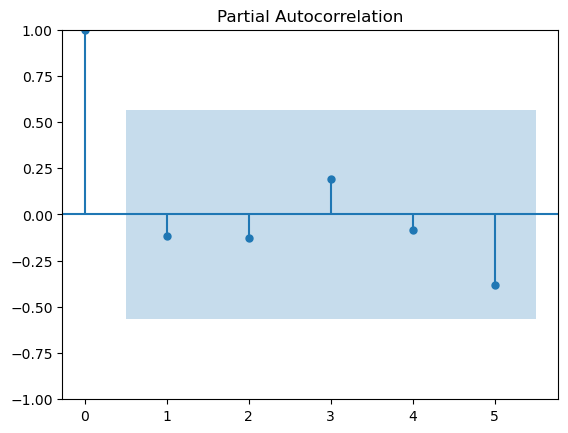

In [85]:
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.arima.model import ARIMA

tsa_plots.plot_acf(full_res, lags = 11)
tsa_plots.plot_pacf(full_res, lags = 5 )

In [87]:
import pmdarima as pm
# help(pm.auto_arima)

ar_model = pm.auto_arima(train.Quantity, start_p = 0, start_q = 0,
                      max_p = 16, max_q = 16, # maximum p and q
                      m = 1,              # frequency of series
                      d = None,           # let model determine 'd'
                      seasonal = False,   # No Seasonality
                      start_P = 0, trace = True,
                      error_action = 'warn', stepwise = True)

# Print model summary
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=225.331, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=188.013, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=186.510, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.657 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 26 May 2024   Prob (F-statistic):                nan
Time:                        11:31:28   Log-Likelihood:                 292.45
No. Observations:                  12   AIC:                            -560.9
Df Residuals:                       0   BIC:                            -555.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1178.8259        inf          0        nan         nan         nan
Jan[T.True]   730.7377        inf          0        nan         nan         nan
Feb[T.True]   192.0034        inf          0        nan         nan         nan
Mar[T.True]   589.9710        inf          0        nan         nan         nan
Apr[T.True]   480.6407        inf          0        nan         nan         nan
May[T.True]   -15.9876        inf         -0        nan         nan         nan
Jun[T.True]  -675.9140        inf         -0        nan         nan         nan
Jul[T.True]   116.8617        inf          0        nan         nan         nan
Aug[T.True]    54.3393        inf          0        nan         nan         nan
Sep[T.True]  -456.4810        inf         -0        nan         nan         nan
Oct[T.True]  -279.5994        inf         -0        nan         nan         nan
Nov[T.True]   -98.0157        inf         -0        nan         nan         nan
Dec[T.True]   540.2699        inf          0        nan         nan         nan
t             425.2873        inf          0        nan         nan         nan
t_square      -25.8510        inf         -0        nan         nan         nan
==============================================================================
Omnibus:                        2.191   Durbin-Watson:                   1.510
Prob(Omnibus):                  0.334   Jarque-Bera (JB):                1.040
Skew:                           0.719   Prob(JB):                        0.594
Kurtosis:                       2.896   Cond. No.                         248.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The input rank is higher than the number of observations.
"""

In [88]:
# Predictions on test set
predictions =ar_model.predict(n_periods=len(test))

# Calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test.Quantity, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 328.134


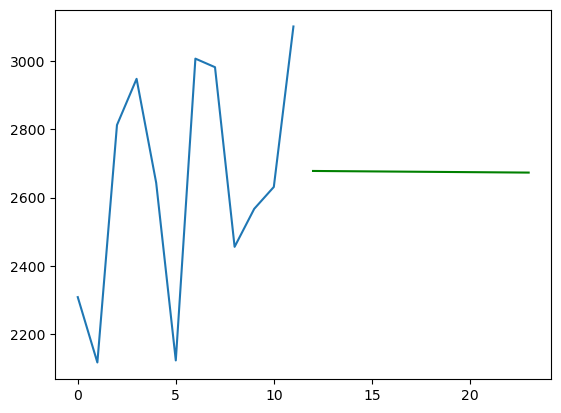

In [89]:
# Plot predictions against actual values
plt.plot(test.Quantity)
plt.plot(predictions, color='green')
plt.show()

# Auto ARIMA

In [90]:
model = ARIMA(train.Quantity, order = (1,0,1))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Quantity   No. Observations:                   12
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -85.332
Date:                Sun, 26 May 2024   AIC                            178.665
Time:                        11:33:42   BIC                            180.604
Sample:                             0   HQIC                           177.946
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2650.9313     46.568     56.926      0.000    2559.660    2742.203
ar.L1          0.2999      0.770      0.390      0.697      -1.208       1.808
ma.L1         -0.9992    178.994     -0.006      0.996    -351.820     349.822
sigma2       7.44e+04   1.33e+07      0.006      0.996    -2.6e+07    2.61e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                 0.28
Prob(Q):                              0.60   Prob(JB):                         0.87
Heteroskedasticity (H):               0.38   Skew:                            -0.29
Prob(H) (two-sided):                  0.37   Kurtosis:                         2.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
# Forecast for next 12 months
start_index = len(Train)
end_index = start_index + 11
forecast_best = res.predict(start = start_index, end = end_index)


forecast_best

12    2412.942576
13    2579.565416
14    2629.530762
15    2644.513916
16    2649.006929
17    2650.354253
18    2650.758276
19    2650.879431
20    2650.915762
21    2650.926656
22    2650.929923
23    2650.930903
Name: predicted_mean, dtype: float64

In [92]:
# Evaluate forecasts
rmse_best = sqrt(mean_squared_error(test.Quantity, forecast_best))
print('Test RMSE: %.3f' % rmse_best)

Test RMSE: 303.864


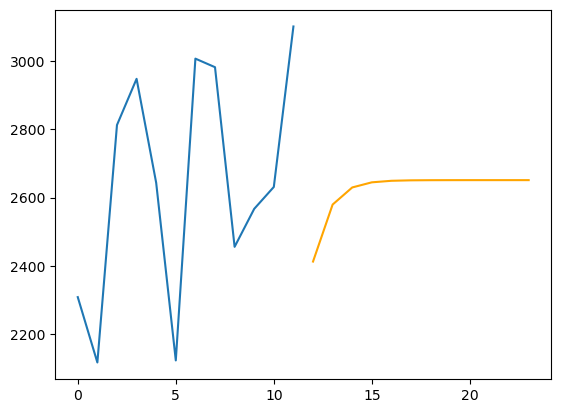

In [95]:
# Plot forecasts against actual outcomes
plt.plot(test.Quantity)
plt.plot(forecast_best, color = 'orange')
plt.show()

# Holt-Winters Method

In [96]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

In [97]:
# Fit an Exponential Smoothing model to the data
model = ExponentialSmoothing(df_grouped['Quantity'], seasonal_periods=4, trend='add', seasonal='mul')
model_fit = model.fit()

In [98]:
# Forecast for the next 12 periods
forecast = model_fit.forecast(steps=12)
forecast

12    2595.286847
13    2405.123034
14    2963.808438
15    3122.636114
16    2637.823506
17    2444.382052
18    3011.990304
19    3173.194522
20    2680.360166
21    2483.641070
22    3060.172170
23    3223.752929
dtype: float64

In [99]:
# Prepare train and test datasets
train =df_grouped.Quantity
test =df_grouped.Quantity

In [100]:
mape= np.mean(np.abs((test - forecast) / test)) * 100
print("MAPE:",mape)

MAPE: nan


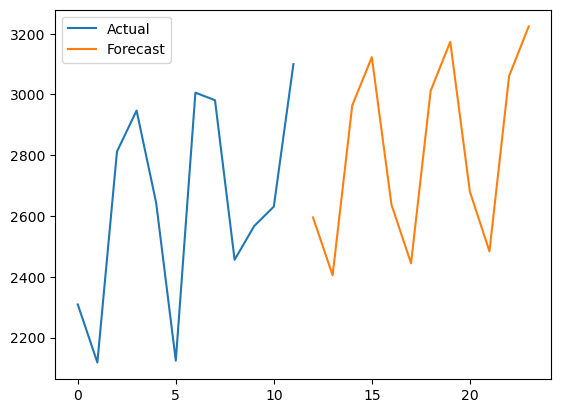

In [101]:
plt.plot(df_grouped['Quantity'], label='Actual')
plt.plot(forecast.index, forecast , label='Forecast')
plt.legend()
plt.show()

In [102]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

In [103]:
# Fit an Exponential Smoothing model to the data
model = ExponentialSmoothing(df_grouped['Quantity'], seasonal_periods=4, trend='mul', seasonal='add')
model_fit = model.fit()

In [104]:
# Forecast for next 12 periods
forecast = model_fit.forecast(steps=12)
forecast

12     2814.446046
13     3046.696628
14     4211.809347
15     4881.522858
16     4842.024306
17     5349.015964
18     6826.097747
19     7850.052780
20     8212.796213
21     9176.534483
22    11172.252996
23    12785.121115
dtype: float64

In [105]:
# Prepare train and test datasets
train = df_grouped.Quantity
test = df_grouped.Quantity

In [106]:
# Calculate root mean squared error (RMSE) of the forecast
mape= np.mean(np.abs((test - forecast) / test)) * 100
print("MAPE:",mape)

rmse = np.sqrt(mean_squared_error(test, forecast))
print("RMSE:", rmse)

MAPE: nan
RMSE: 5032.711977063249


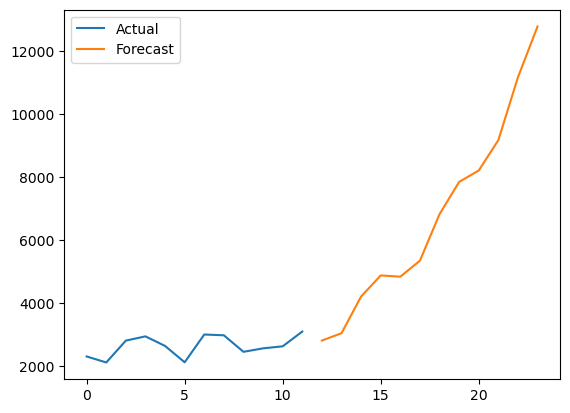

In [107]:
plt.plot(df_grouped['Quantity'], label='Actual')
plt.plot(forecast.index, forecast , label='Forecast')
plt.legend()
plt.show()

In [108]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Fit an Exponential Smoothing model to the data
model = ExponentialSmoothing(df_grouped['Quantity'], seasonal_periods=4, trend='add', seasonal='add')
model_fit = model.fit()

# Forecast for the next 12 periods
forecast = model_fit.forecast(steps=12)
forecast

12    2588.158390
13    2385.327452
14    2934.529011
15    3124.798641
16    2635.945335
17    2433.114396
18    2982.315956
19    3172.585585
20    2683.732279
21    2480.901340
22    3030.102900
23    3220.372529
dtype: float64

In [109]:
# Prepare train and test datasets
train = df_grouped.Quantity
test = df_grouped.Quantity

# Calculate root mean squared error (RMSE) of the forecast
mape= np.mean(np.abs((test - forecast) / test)) * 100
print("MAPE:",mape)
rmse = np.sqrt(mean_squared_error(test, forecast))
print("RMSE:", rmse)

MAPE: nan
RMSE: 216.39743099024673


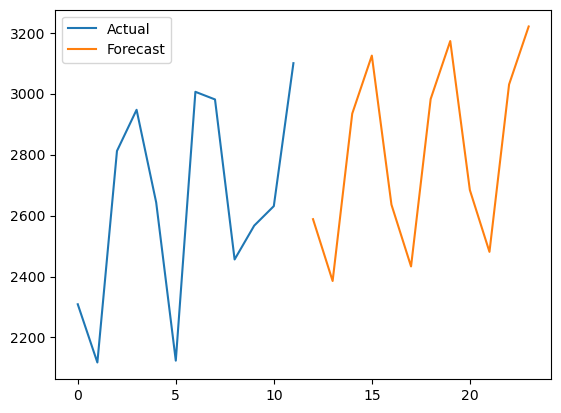

In [110]:
plt.plot(df_grouped['Quantity'], label='Actual')
plt.plot(forecast.index, forecast , label='Forecast')
plt.legend()
plt.show()

In [111]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt-Winters method on training data
hw_model = ExponentialSmoothing(Train['Quantity'], seasonal_periods=6, trend='add', seasonal='add').fit()

# Predictions on test data using the fitted model
pred_hw = hw_model.forecast(len(Test))

# Calculate MAPE between predicted and actual values
mape_hw = np.mean(np.abs((Test['Quantity'] - pred_hw) / Test['Quantity'])) * 100
mape_hw

nan

In [112]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Fit an Exponential Smoothing model to the data
model = ExponentialSmoothing(df_grouped['Quantity'], seasonal_periods=4, trend='mul', seasonal='mul')
model_fit = model.fit()

# Forecast for the next 12 periods
forecast = model_fit.forecast(steps=12)
forecast

12     2711.673811
13     2781.487457
14     4129.710668
15     4839.565928
16     4239.865995
17     4349.023852
18     6457.052377
19     7566.954005
20     6629.286892
21     6799.961803
22    10095.991886
23    11831.390203
dtype: float64

In [113]:
# Prepare train and test datasets
train =df_grouped.Quantity
test =df_grouped.Quantity

# Calculate root mean squared error (RMSE) of the forecast
rmse = np.sqrt(mean_squared_error(test, forecast))
print("RMSE:", rmse)

RMSE: 4219.592650534886


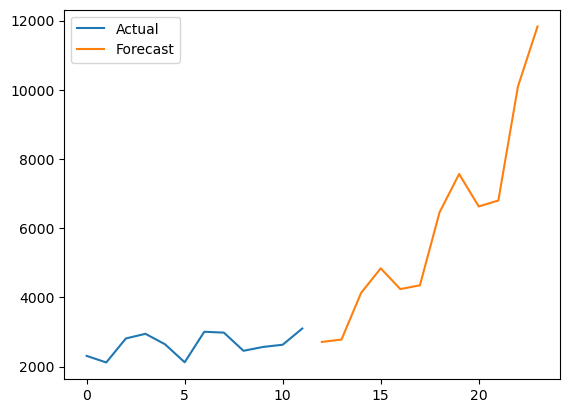

In [114]:
plt.plot(df_grouped['Quantity'], label='Actual')
plt.plot(forecast.index, forecast , label='Forecast')
plt.legend()
plt.show()

In [115]:
# Date column as index
# df_grouped.set_index('Dateofbill', inplace=True)
# Computed rolling mean of the sales data using SES

alpha =1   # smoothing parameter
df_grouped['SES'] = df_grouped['Quantity'].ewm(alpha=alpha, adjust=False).mean()

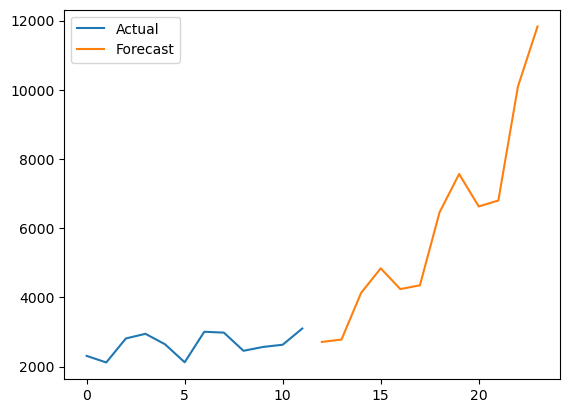

In [116]:
plt.plot(df_grouped['Quantity'], label='Actual')
plt.plot(forecast.index, forecast , label='Forecast')
plt.legend()
plt.show()

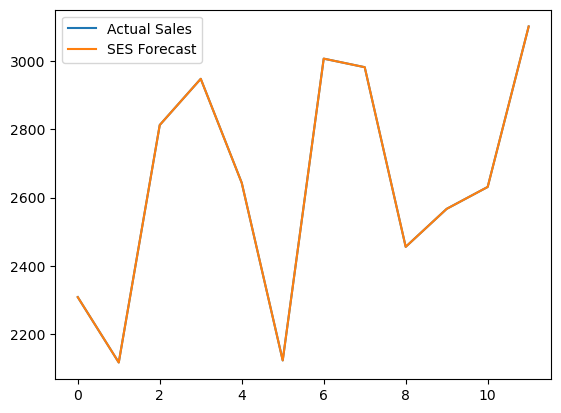

In [117]:
# Plot  of original sales data and the SES forecast
plt.plot(df_grouped['Quantity'], label='Actual Sales')
plt.plot(df_grouped['SES'], label='SES Forecast')
plt.legend()
plt.show()

# Random Forest & Linear Regression Model

In [118]:
df = data[['Dateofbill', 'Quantity']]

In [119]:
df.index.freq = 'MS'

In [120]:
df.head(10)

,Dateofbill,Quantity
0,Jan,2309
1,Feb,2118
2,Mar,2812
3,Apr,2947
4,May,2643
5,Jun,2124
6,Jul,3006
7,Aug,2981
8,Sep,2456
9,Oct,2567


In [121]:
df.set_index('Dateofbill')

,Quantity
Dateofbill,
Jan,2309
Feb,2118
Mar,2812
Apr,2947
May,2643
Jun,2124
Jul,3006
Aug,2981
Sep,2456


<Axes: >

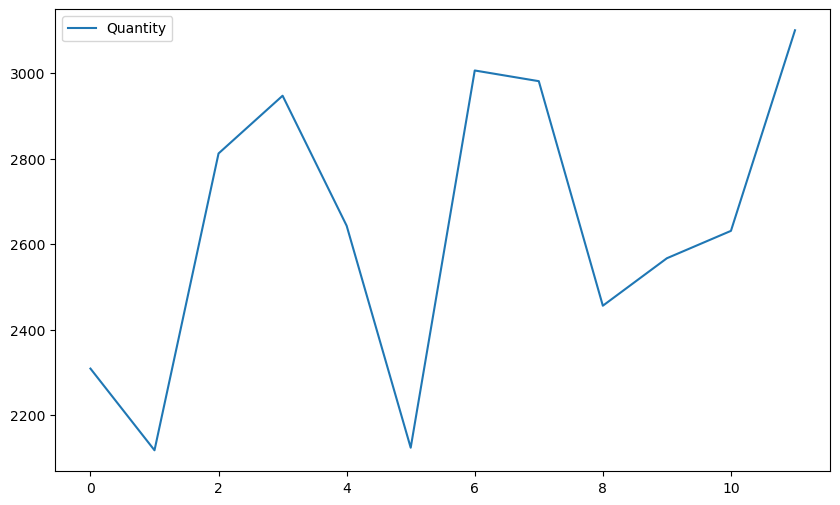

In [122]:
df.plot(figsize=(10,6))

In [123]:
df['Quantity_LastMonth']=df['Quantity'].shift(+1)
df['Quantity_2Monthsback']=df['Quantity'].shift(+2)
df['Quantity_3Monthsback']=df['Quantity'].shift(+3)
df

,Dateofbill,Quantity,Quantity_LastMonth,Quantity_2Monthsback,Quantity_3Monthsback
0,Jan,2309,NaN,NaN,NaN
1,Feb,2118,2309.0,NaN,NaN
2,Mar,2812,2118.0,2309.0,NaN
3,Apr,2947,2812.0,2118.0,2309.0
4,May,2643,2947.0,2812.0,2118.0
5,Jun,2124,2643.0,2947.0,2812.0
6,Jul,3006,2124.0,2643.0,2947.0
7,Aug,2981,3006.0,2124.0,2643.0
8,Sep,2456,2981.0,3006.0,2124.0
9,Oct,2567,2456.0,2981.0,3006.0


In [124]:
df = df.dropna()
df

,Dateofbill,Quantity,Quantity_LastMonth,Quantity_2Monthsback,Quantity_3Monthsback
3,Apr,2947,2812.0,2118.0,2309.0
4,May,2643,2947.0,2812.0,2118.0
5,Jun,2124,2643.0,2947.0,2812.0
6,Jul,3006,2124.0,2643.0,2947.0
7,Aug,2981,3006.0,2124.0,2643.0
8,Sep,2456,2981.0,3006.0,2124.0
9,Oct,2567,2456.0,2981.0,3006.0
10,Nov,2631,2567.0,2456.0,2981.0
11,Dec,3100,2631.0,2567.0,2456.0


In [125]:
from sklearn.linear_model import LinearRegression
lin_model=LinearRegression()

In [126]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)

2024-05-26 11:59:11,418 - INFO     - Executing shutdown due to inactivity...


In [127]:
import numpy as np
x1,x2,x3,y=df['Quantity_LastMonth'],df['Quantity_2Monthsback'],df['Quantity_3Monthsback'],df['Quantity']
x1,x2,x3,y=np.array(x1),np.array(x2),np.array(x3),np.array(y)
x1,x2,x3,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
final_x=np.concatenate((x1,x2,x3),axis=1)
print(final_x)

[[2812. 2118. 2309.]
 [2947. 2812. 2118.]
 [2643. 2947. 2812.]
 [2124. 2643. 2947.]
 [3006. 2124. 2643.]
 [2981. 3006. 2124.]
 [2456. 2981. 3006.]
 [2567. 2456. 2981.]
 [2631. 2567. 2456.]]


In [128]:
X_train,X_test,y_train,y_test=final_x[:],final_x[-10:],y[:],y[-10:]

In [129]:
model.fit(X_train,y_train)
lin_model.fit(X_train,y_train)

LinearRegression()

# Random Forest Regression

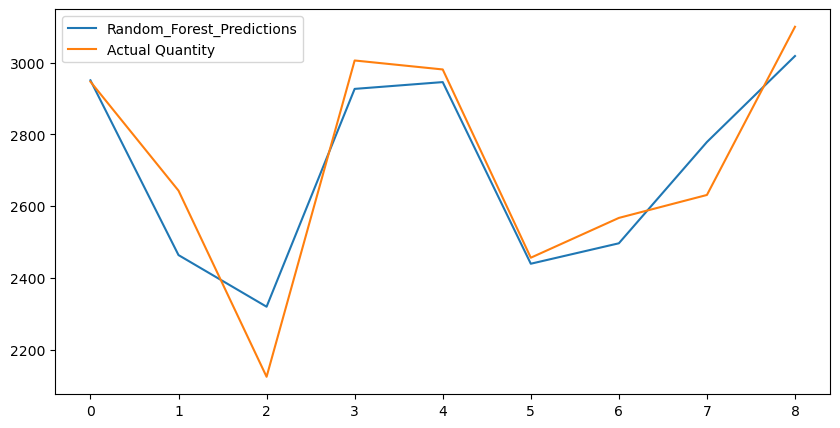

In [130]:
pred = model.predict(X_test)
plt.rcParams["figure.figsize"] = (10, 5)
plt.plot(pred, label='Random_Forest_Predictions')
plt.plot(y_test, label='Actual Quantity')
plt.legend(loc="upper left")
plt.show()

# Linear Forest Regression

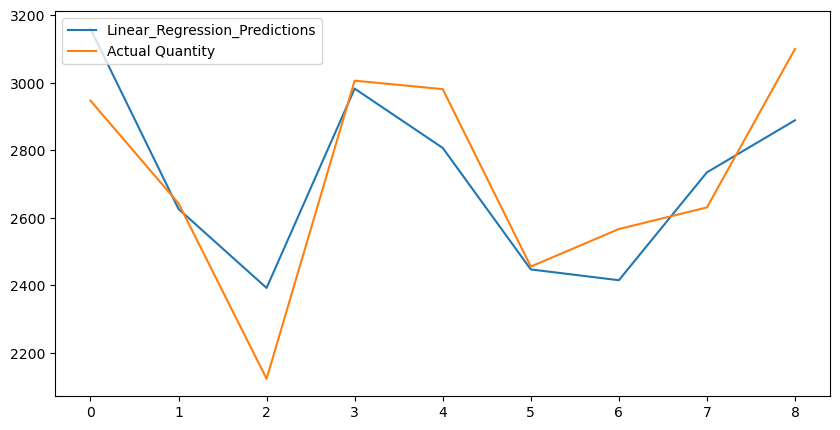

In [131]:
lin_pred=lin_model.predict(X_test)
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(lin_pred, label='Linear_Regression_Predictions')
plt.plot(y_test,label='Actual Quantity')
plt.legend(loc="upper left")
plt.show()

In [132]:
rmse_rf=sqrt(mean_squared_error(pred,y_test))
rmse_lr=sqrt(mean_squared_error(lin_pred,y_test))

In [133]:
print('Mean Squared Error for Random Forest Model is:',rmse_rf)
print('Mean Squared Error for Linear Regression Model is:',rmse_lr)

Mean Squared Error for Random Forest Model is: 111.41388986816473
Mean Squared Error for Linear Regression Model is: 158.76027698565989
